# Skin segmentation

In this assignement you will train classifier to assign colors to skin or no skin classes. The data is taken from [Skin Segmentation Data Set](http://archive.ics.uci.edu/ml/datasets/Skin+Segmentation#) in the UCI Machine Learning repository.

The  data is in a plain text format and contains four columns. First three contain RGB color data  represented as integers in the range 0-255, and the last column is an integer label  with 1 representing skin and 2 representing no skin. This file we can load directly into a numpy array:

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn

In [14]:
data = np.loadtxt('data/Skin_NonSkin.txt')

In [15]:
rgb  = data[:,:3].astype('float32')
lbl = data[:,3].astype('float32') 
lbl = 2-lbl # 1-skin, 0-not skin; >0.5 rcognized as skin

In [16]:
len(data)

245057

In [17]:
np.bincount(lbl.astype('int32'))

array([194198,  50859])

## Problem 1

Train the neural network to distinguish skin from no skin colors. Calculate the accuracy on train and validation sets. Calculate true positives rate and false positives rate.

In [18]:
model = nn.Sequential(
    nn.Linear(3, 30), # transforms incoming 3 features into output of 30 features
    nn.ReLU(), # Applies the rectified linear unit function element-wise
    nn.Linear(30, 60),
    nn.ReLU(),
    nn.Linear(60, 20),
    nn.ReLU(),
    nn.Linear(20, 1),
    nn.Sigmoid() # Applies the element-wise function
)

In [19]:
params = {
    'batch_size': 600,
    'num_workers': 10, #multi-process data loading
}

# data to pytorch Tensors
x_data = torch.from_numpy(rgb)
y_data = torch.from_numpy(lbl)

dataset = torch.utils.data.TensorDataset(x_data, y_data)
training_dataset, test_dataset = torch.utils.data.random_split(dataset, [179652, 65405])
training_generator = torch.utils.data.DataLoader(training_dataset, **params) 
test_generator = torch.utils.data.DataLoader(test_dataset, **params)

# np.bincount(training_dataset)

In [20]:
optimizer=torch.optim.SGD(model.parameters(), lr = 0.003)
# loss_fn = nn.BCEWithLogitsLoss() #gdyby w modelu nie było sigmoid na końcu
loss_fn = nn.BCELoss() # bo w modelu mamy sigmoid

In [21]:
%%time
epochs = 100
train_loss = []
test_acc_list = np.array([])

for e in range(epochs):    
    model.train() # setting model to training mode
    
    #training
    for local_x, local_y in training_generator:    
        optimizer.zero_grad()
        output = model(local_x) #calling model(x)  instead of forward(x); outputs predictions
        loss = loss_fn(output, local_y.reshape(-1, 1))
        
        loss.backward()
        optimizer.step()
    
        train_loss.append(loss.item())
           
    if e % 10 == 0:
        print(f"Epoch {str(e)} -> {str(loss.item())}")

Epoch 0 -> 0.1070714071393013
Epoch 10 -> 0.021361200138926506
Epoch 20 -> 0.012052584439516068
Epoch 30 -> 0.008102145977318287
Epoch 40 -> 0.005947216879576445
Epoch 50 -> 0.00476595526561141
Epoch 60 -> 0.00395174277946353
Epoch 70 -> 0.00342016969807446
Epoch 80 -> 0.003053551074117422
Epoch 90 -> 0.0027844454161822796
CPU times: user 4min 24s, sys: 9.27 s, total: 4min 34s
Wall time: 1min 19s


In [41]:
model.eval()
with torch.no_grad():
    total=0
    count=0
    for local_x, local_y in test_generator:
        local_y = local_y.reshape(-1, 1)
        test_pred = model(local_x)
        test_pred = (test_pred > 0.5)
        total += torch.sum((test_pred == local_y ).type(torch.FloatTensor))
        count += len(local_y)
    
    val_acc = total/count;
    print('acc = ', val_acc)

acc =  tensor(0.9974)


In [31]:
# print(model.state_dict())

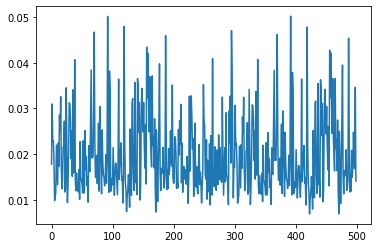

In [47]:
plt.plot(train_loss[5000:5500])
plt.show()